In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
folder_glance = '/projectnb/measures/products/SA/v001/DAAC/LC/'
file = folder_glance + 'GLANCE.A20060701.h54v22.001.20240219.SA.LC.tif'


In [7]:
import rasterio
with rasterio.open(file) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)


CRS: EPSG:10603
Bounds: BoundingBox(left=1181230.0, bottom=1449705.0, right=1331230.0, top=1599705.0)


In [16]:
import leafmap
import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
import tempfile
import os

# --- 1. Reproject to EPSG:4326 in /tmp (keep for later cells) ---
with tempfile.NamedTemporaryFile(suffix='_wgs84.tif', delete=False) as tmpfile:
    tmp_path = tmpfile.name

with rasterio.open(file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:4326', src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:4326',
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(tmp_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:4326',
                resampling=Resampling.nearest
            )

print(f"Reprojected file: {tmp_path}")

# --- 2. Try multiple rendering approaches ---
with rasterio.open(tmp_path) as src:
    bounds = src.bounds
    center_lat = (bounds.bottom + bounds.top) / 2
    center_lon = (bounds.left + bounds.right) / 2

# Option A: Basic leafmap with explicit widget display
m = leafmap.Map(center=[center_lat, center_lon], zoom=9)
m.add_basemap("OpenStreetMap")

try:
    m.add_raster(
        tmp_path,
        layer_name="GLANCE LC",
        colormap="tab20",
        opacity=0.7
    )
    print("✓ Raster added successfully")
except Exception as e:
    print(f"✗ add_raster failed: {e}")
    # Fallback: try add_geotiff
    try:
        m.add_geotiff(tmp_path, layer_name="GLANCE LC", colormap="tab20")
        print("✓ Used add_geotiff instead")
    except Exception as e2:
        print(f"✗ add_geotiff also failed: {e2}")

# Force display
display(m)


Reprojected file: /projectnb/modislc/users/chishan/tmp/tmpmmfmbj2__wgs84.tif
OpenStreetMap has been already added before.
✓ Raster added successfully


Map(center=[-0.9586125, -48.7762235], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [17]:
# Alternative: Use folium directly (more reliable for remote jupyter)
import folium
from folium import raster_layers
import numpy as np

with rasterio.open(tmp_path) as src:
    data = src.read(1)
    bounds = src.bounds
    center_lat = (bounds.bottom + bounds.top) / 2
    center_lon = (bounds.left + bounds.right) / 2
    
    # Create folium map
    m2 = folium.Map(location=[center_lat, center_lon], zoom_start=9)
    
    # Add the raster as an image overlay
    # Note: For large rasters, this may be slow. Consider downsampling.
    img_bounds = [[bounds.bottom, bounds.left], [bounds.top, bounds.right]]
    
    # Normalize data for display (0-255)
    data_normalized = ((data - data.min()) / (data.max() - data.min()) * 255).astype(np.uint8)
    
    folium.raster_layers.ImageOverlay(
        image=data_normalized,
        bounds=img_bounds,
        opacity=0.7,
        name='GLANCE LC',
        colormap=lambda x: plt.cm.tab20(x/255.0)[:3]  # RGB only
    ).add_to(m2)
    
    folium.LayerControl().add_to(m2)

print(f"Map centered at: ({center_lat:.4f}, {center_lon:.4f})")
m2


KeyboardInterrupt: 

In [5]:
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import tempfile

src = "/projectnb/measures/products/SA/v001/DAAC/LC/GLANCE.A20060701.h54v22.001.20240219.SA.LC.tif"

# Step 1: Reproject to EPSG:4326 first (leafmap needs WGS84 or Web Mercator)
with tempfile.NamedTemporaryFile(suffix='_wgs84.tif', delete=False) as tmp_wgs:
    wgs84_path = tmp_wgs.name

with rasterio.open(src) as src_ds:
    transform, width, height = calculate_default_transform(
        src_ds.crs, 'EPSG:4326', src_ds.width, src_ds.height, *src_ds.bounds
    )
    kwargs = src_ds.meta.copy()
    kwargs.update({
        'crs': 'EPSG:4326',
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.open(wgs84_path, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src_ds, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src_ds.transform,
            src_crs=src_ds.crs,
            dst_transform=transform,
            dst_crs='EPSG:4326',
            resampling=Resampling.nearest
        )

print(f"Reprojected to WGS84: {wgs84_path}")

# Step 2: Convert reprojected file to COG
with tempfile.NamedTemporaryFile(suffix='_cog.tif', delete=False) as tmp_cog:
    cog = tmp_cog.name

cog_translate(wgs84_path, cog, cog_profiles.get("deflate"))
print(f"COG created: {cog}")

# Step 3: Add to leafmap
import leafmap
with rasterio.open(cog) as src:
    bounds = src.bounds
    center_lat = (bounds.bottom + bounds.top) / 2
    center_lon = (bounds.left + bounds.right) / 2
    print(f"Center: ({center_lat:.4f}, {center_lon:.4f})")
    print(f"Data range: {src.read(1).min()} - {src.read(1).max()}")
    
m = leafmap.Map(center=[center_lat, center_lon], zoom=8)
# m.add_local_tile(cog, layer_name="GLANCE LC", opacity=0.8)
m.add_raster(
    cog,
    layer_name="GLANCE LC",
    colormap="Set3",  # 离散色盘
    vmin=1,
    vmax=7,
    opacity=0.8
)
m


Reading input: /projectnb/modislc/users/chishan/tmp/tmpy7xu8l30_wgs84.tif




Reprojected to WGS84: /projectnb/modislc/users/chishan/tmp/tmpy7xu8l30_wgs84.tif


Adding overviews...
Updating dataset tags...
Writing output to: /projectnb/modislc/users/chishan/tmp/tmpqpnq2qlw_cog.tif
Updating dataset tags...
Writing output to: /projectnb/modislc/users/chishan/tmp/tmpqpnq2qlw_cog.tif


COG created: /projectnb/modislc/users/chishan/tmp/tmpqpnq2qlw_cog.tif
Center: (-0.9586, -48.7762)
Data range: 1 - 255


Map(center=[-0.9586125, -48.7762235], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [4]:
import numpy as np
with rasterio.open(cog) as src:
    arr = src.read(1)
    print("Unique values:", np.unique(arr))


Unique values: [  1   3   4   5   6   7 255]


In [29]:
# Alternative: Use ipyleaflet directly (more reliable for remote jupyter)
from ipyleaflet import Map, basemaps, ImageOverlay
from ipywidgets import Layout
import numpy as np
import rasterio
from PIL import Image
import io
import base64

with rasterio.open(cog) as src:
    data = src.read(1)
    bounds = src.bounds
    center_lat = (bounds.bottom + bounds.top) / 2
    center_lon = (bounds.left + bounds.right) / 2
    
    print(f"Data range: {data.min()} - {data.max()}")
    print(f"Bounds: {bounds}")
    print(f"Center: ({center_lat:.4f}, {center_lon:.4f})")
    
    # Create discrete colormap for categorical data
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab20', 256)  # Use 256 for full range

    # Normalize to 0-1 range for colormap
    data_norm = (data - data.min()) / (data.max() - data.min())
    rgb = (cmap(data_norm)[:, :, :3] * 255).astype(np.uint8)
    
    print(f"RGB shape: {rgb.shape}")
    
    # Convert to PNG in memory
    img = Image.fromarray(rgb)
    buf = io.BytesIO()
    img.save(buf, format='PNG')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode()
    
    print(f"PNG size: {len(img_base64)} bytes (base64)")

# Create ipyleaflet map with basemap first
m3 = Map(
    center=(center_lat, center_lon),
    zoom=8,
    basemap=basemaps.Esri.WorldImagery,
    layout=Layout(width='100%', height='600px')
)

# Add image overlay on TOP of basemap
image_overlay = ImageOverlay(
    url=f'data:image/png;base64,{img_base64}',
    bounds=((bounds.bottom, bounds.left), (bounds.top, bounds.right)),
    name='GLANCE LC',
    opacity=1.0  # Full opacity to test visibility
)
m3.add_layer(image_overlay)

print("✓ Image overlay added to map")
m3


Data range: 1 - 255
Bounds: BoundingBox(left=-49.45863133286555, bottom=-1.6649342285359634, right=-48.09381570921764, top=-0.25229127586828476)
Center: (-0.9586, -48.7762)
RGB shape: (5287, 5108, 3)
RGB shape: (5287, 5108, 3)
PNG size: 125284 bytes (base64)
✓ Image overlay added to map
PNG size: 125284 bytes (base64)
✓ Image overlay added to map


Map(center=[-0.958612752202124, -48.776223521041594], controls=(ZoomControl(options=['position', 'zoom_in_text…

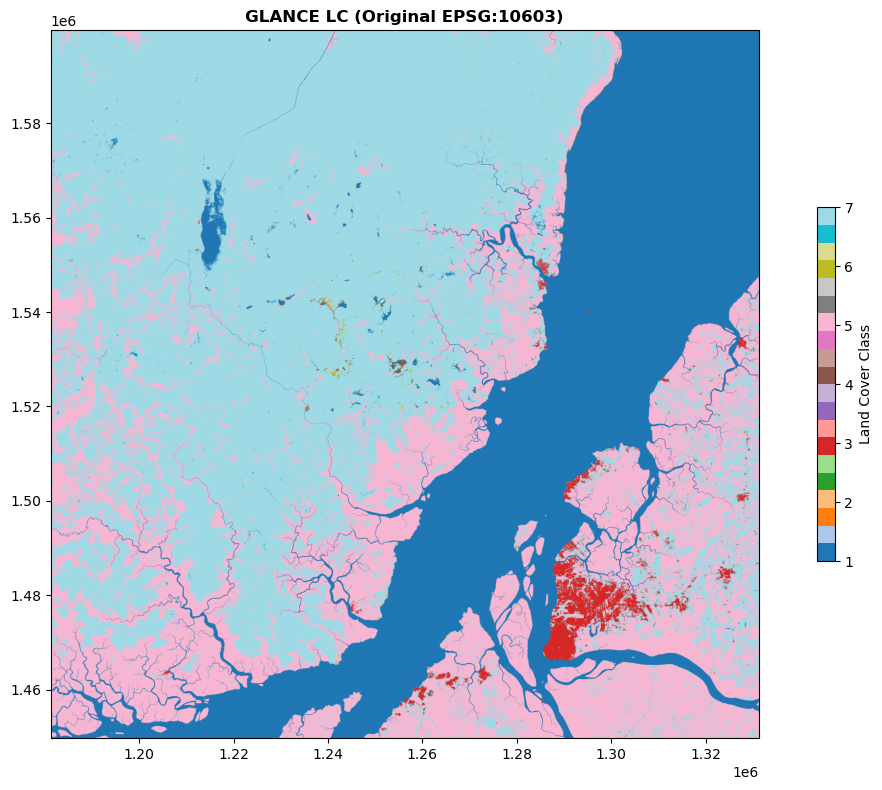

Shape: (5000, 5000)
CRS: EPSG:10603
Bounds: BoundingBox(left=1181230.0, bottom=1449705.0, right=1331230.0, top=1599705.0)
Data range: 1 - 255


In [12]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

# Quick plot of original raster
with rasterio.open(file) as src:
    fig, ax = plt.subplots(figsize=(12, 8))
    show(src, ax=ax, cmap='tab20', title='GLANCE LC (Original EPSG:10603)')
    plt.colorbar(ax.images[0], ax=ax, shrink=0.5, label='Land Cover Class')
    plt.tight_layout()
    plt.show()
    
    print(f"Shape: {src.shape}")
    print(f"CRS: {src.crs}")
    print(f"Bounds: {src.bounds}")
    print(f"Data range: {src.read(1).min()} - {src.read(1).max()}")


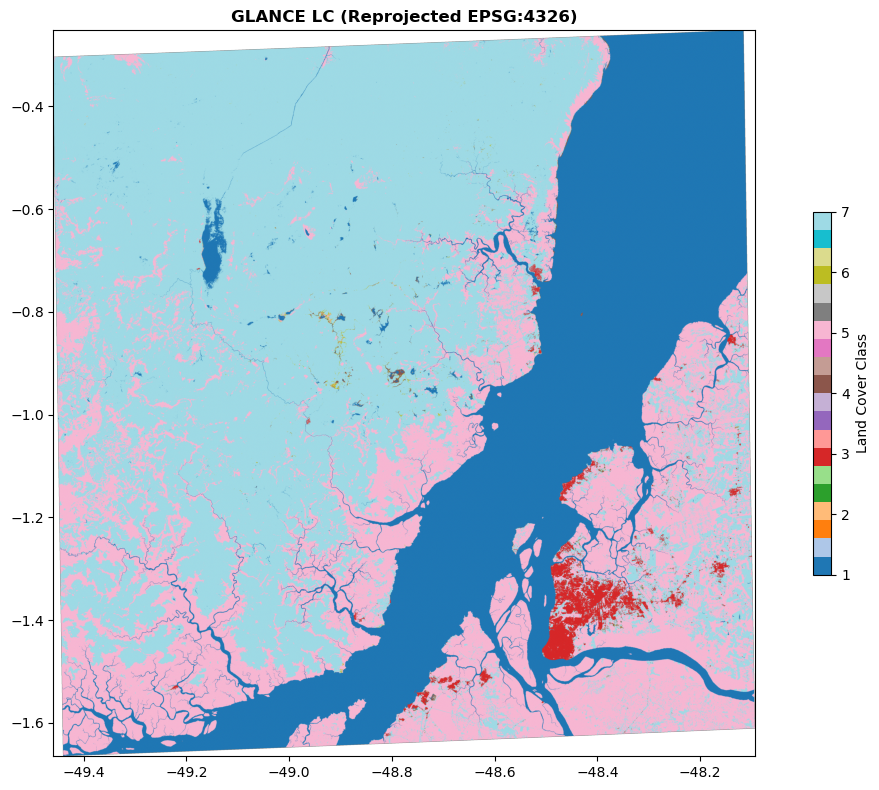

Shape: (5287, 5108)
CRS: EPSG:4326
Bounds: BoundingBox(left=-49.45863133286555, bottom=-1.6649342285359634, right=-48.09381570921764, top=-0.25229127586828476)
Data range: 1 - 255


In [15]:
# Plot the reprojected WGS84 version
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

with rasterio.open(tmp_path) as src:
    fig, ax = plt.subplots(figsize=(12, 8))
    show(src, ax=ax, cmap='tab20', title='GLANCE LC (Reprojected EPSG:4326)')
    plt.colorbar(ax.images[0], ax=ax, shrink=0.5, label='Land Cover Class')
    plt.tight_layout()
    plt.show()
    
    print(f"Shape: {src.shape}")
    print(f"CRS: {src.crs}")
    print(f"Bounds: {src.bounds}")
    print(f"Data range: {src.read(1).min()} - {src.read(1).max()}")


In [23]:
# Clean up temp file when done
import os
if 'tmp_path' in globals() and os.path.exists(tmp_path):
    os.unlink(tmp_path)
    print(f"Deleted: {tmp_path}")


Deleted: /projectnb/modislc/users/chishan/tmp/tmpmmfmbj2__wgs84.tif


In [13]:
import pystac_client
pystac_client.__version__


'0.9.0'

In [14]:
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')
for collection in service.get_collections():
    print(collection)


<CollectionClient id=sentinel-3-olci-l1-bundle-1>
<CollectionClient id=landsat-2>
<CollectionClient id=mosaic-cbers4a-paraiba-3m-1>
<CollectionClient id=LCC_L8_30_16D_STK_Cerrado-1>
<CollectionClient id=mosaic-landsat-sp-6m-1>
<CollectionClient id=CB2B-CCD-L2-DN-1>
<CollectionClient id=GOES19-L2-CMI-1>
<CollectionClient id=mosaic-s2-paraiba-3m-1>
<CollectionClient id=LCC_L8_30_16D_STK_MataAtlantica-1>
<CollectionClient id=mosaic-s2-yanomami_territory-6m-1>
<CollectionClient id=LANDSAT-16D-1>
<CollectionClient id=LCC_L8_30_16D_STK_Pantanal-1>
<CollectionClient id=LCC_L8_30_1M_STK_Cerrado-1>
<CollectionClient id=S2_L1C_BUNDLE-1>
<CollectionClient id=MODISA-OCSMART-RRS-MONTHLY-1>
<CollectionClient id=mosaic-s2-renovamap-1>
<CollectionClient id=CB4A-WFI-L4-SR-1>
<CollectionClient id=prec_merge_hourly-1>
<CollectionClient id=S2-16D-2>
<CollectionClient id=mosaic-s2-brazil-3m-1>
<CollectionClient id=S2_L2A-1>
<CollectionClient id=mod11a2-6.1>
<CollectionClient id=S2_L2A_BUNDLE-1>
<Collection

# High-Performance Land Cover Comparison for Amazon 2018
## Using Dask for distributed processing of tiled GLANCE data

# TerraClass Amazon Data Processing
## Parse QML legend and reclassify to Forest/Non-Forest

In [20]:
import xml.etree.ElementTree as ET

def parse_qml_legend(qml_path):
    """
    Parse QGIS QML file to extract class values and labels
    
    Parameters:
    -----------
    qml_path : str
        Path to .qml file
    
    Returns:
    --------
    dict : Dictionary mapping pixel values to class names
    """
    tree = ET.parse(qml_path)
    root = tree.getroot()
    
    classes = {}
    
    # QML files typically have paletteEntry elements with value and label
    for entry in root.findall('.//paletteEntry'):
        value = entry.get('value')
        label = entry.get('label')
        if value and label:
            classes[int(value)] = label
    
    # Alternative: Look for item elements in categorizedrenderer
    if not classes:
        for item in root.findall('.//category'):
            value = item.get('value')
            label = item.get('label')
            if value and label:
                classes[int(value)] = label
    
    print(f"Parsed {len(classes)} classes from QML file:")
    for val, label in sorted(classes.items()):
        print(f"  {val}: {label}")
    
    return classes

# Example usage - update path to your QML file
folder_terra = '/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/'
REF_TIF = folder_terra + 'AMZ.2016.M.tif'

qml_file = folder_terra + 'AMZ.2016.M.qml'
classes = parse_qml_legend(qml_file)
print("QML parser ready. Update qml_file path to use.")


Parsed 16 classes from QML file:
  1: VEGETACAO NATURAL FLORESTAL PRIMARIA
  2: VEGETACAO NATURAL FLORESTAL SECUNDARIA
  9: SILVICULTURA
  10: PASTAGEM ARBUSTIVA/ARBOREA
  11: PASTAGEM HERBACEA
  12: CULTURA AGRICOLA PERENE
  13: CULTURA AGRICOLA SEMIPERENE
  14: CULTURA AGRICOLA TEMPORARIA DE 1 CICLO
  15: CULTURA AGRICOLA TEMPORARIA DE MAIS DE 1 CICLO
  16: MINERACAO
  17: URBANIZADA
  20: OUTROS USOS
  22: DESFLORESTAMENTO NO ANO
  23: CORPO DAGUA
  25: NAO OBSERVADO
  51: NATURAL NAO FLORESTAL
QML parser ready. Update qml_file path to use.


In [ ]:
# Create MapBiomas-specific forest reclassification
def create_mapbiomas_forest_map(classes_dict):
    """
    Create forest/non-forest reclassification for MapBiomas Amazon classes
    
    MapBiomas Forest Classes:
    - 1: VEGETACAO NATURAL FLORESTAL PRIMARIA (Primary Forest)
    - 2: VEGETACAO NATURAL FLORESTAL SECUNDARIA (Secondary Forest)
    
    MapBiomas Non-Forest Classes:
    - 9: SILVICULTURA (Forestry/Plantation)
    - 10: PASTAGEM ARBUSTIVA/ARBOREA (Shrubby/Tree Pasture)
    - 11: PASTAGEM HERBACEA (Herbaceous Pasture)
    - 12: CULTURA AGRICOLA PERENE (Perennial Agriculture)
    - 13: CULTURA AGRICOLA SEMIPERENE (Semi-perennial Agriculture)
    - 14: CULTURA AGRICOLA TEMPORARIA DE 1 CICLO (1-cycle Agriculture)
    - 15: CULTURA AGRICOLA TEMPORARIA DE MAIS DE 1 CICLO (Multi-cycle Agriculture)
    - 16: MINERACAO (Mining)
    - 17: URBANIZADA (Urban)
    - 20: OUTROS USOS (Other Uses)
    - 22: DESFLORESTAMENTO NO ANO (Deforestation in year)
    - 23: CORPO DAGUA (Water Body)
    - 25: NAO OBSERVADO (Not Observed)
    - 51: NATURAL NAO FLORESTAL (Natural Non-Forest)
    
    Parameters:
    -----------
    classes_dict : dict
        Dictionary from parse_qml_legend()
    
    Returns:
    --------
    dict : Reclassification map (value -> 1=Forest, 0=Non-Forest)
    """
    # Define forest classes explicitly for MapBiomas
    # FOREST_CLASSES = [1, 2]  # Primary and Secondary Natural Forest only
    
    # Optional: Include plantation forest (silvicultura)
    FOREST_CLASSES = [1, 2, 9]  # Uncomment to include plantations
    
    reclass_map = {}
    for value in classes_dict.keys():
        reclass_map[value] = 1 if value in FOREST_CLASSES else 0
    
    # Print detailed classification
    print("\n" + "=" * 80)
    print("MAPBIOMAS AMAZON FOREST RECLASSIFICATION")
    print("=" * 80)
    
    print("\n🌳 FOREST Classes (mapped to 1):")
    for value, label in sorted(classes_dict.items()):
        if reclass_map[value] == 1:
            print(f"  {value:3d}: {label}")
    
    print("\n🏞️  NON-FOREST Classes (mapped to 0):")
    for value, label in sorted(classes_dict.items()):
        if reclass_map[value] == 0:
            print(f"  {value:3d}: {label}")
    
    print("\n" + "=" * 80)
    print(f"Total: {sum(1 for v in reclass_map.values() if v == 1)} Forest classes, "
          f"{sum(1 for v in reclass_map.values() if v == 0)} Non-forest classes")
    print("=" * 80)
    
    return reclass_map

# Apply to your parsed classes
reclass_map = create_mapbiomas_forest_map(classes)

# Show the mapping
print("\nReclassification mapping ready!")
print("Note: Only classes 1 (Primary) and 2 (Secondary) Natural Forest are classified as Forest.")
print("      Silvicultura (9, plantation) is treated as Non-Forest by default.")
print("      Uncomment line in function to include plantations as forest if needed.")


In [ ]:
# Load and reclassify MapBiomas to binary forest map
import rioxarray
print("Loading MapBiomas data...")
mapbiomas_ref = rioxarray.open_rasterio(REF_TIF, chunks={'band': 1, 'x': 2048, 'y': 2048}, lock=False)

print(f"  Shape: {mapbiomas_ref.shape}")
print(f"  CRS: {mapbiomas_ref.rio.crs}")
print(f"  Bounds: {mapbiomas_ref.rio.bounds()}")
print(f"  Data type: {mapbiomas_ref.dtype}")

# Check unique values in the data
print("\nChecking data values (this will sample the data)...")
sample = mapbiomas_ref.isel(x=slice(0, 1000), y=slice(0, 1000)).values.ravel()
unique_vals = np.unique(sample[sample != 0])
print(f"Unique values in sample: {unique_vals}")

# Apply reclassification
print("\nApplying forest/non-forest reclassification...")
mapbiomas_binary = reclassify_terraclass_to_forest(mapbiomas_ref, reclass_map, nodata_value=0)

print("\n✓ MapBiomas reclassified to binary forest map!")
print("  Values: 0 = Non-forest, 1 = Forest")


## Ready to Compare: GLANCE vs MapBiomas Forest Classification

In [ ]:
# Step 1: Reclassify GLANCE to binary forest
print("=" * 80)
print("GLANCE vs MapBiomas FOREST COMPARISON - 2018 Amazon")
print("=" * 80)

print("\n[1/5] Reclassifying GLANCE to Forest/Non-Forest...")
glance_binary = reclassify_glance_to_forest(
    glance_2018_mosaic,
    glance_forest_classes=[1, 2, 3, 4, 5]  # All forest types in GLANCE
)

print("\n[2/5] Both datasets now in binary format (1=Forest, 0=Non-Forest)")
print(f"  GLANCE: {glance_binary.shape}")
print(f"  MapBiomas: {mapbiomas_binary.shape}")

print("\n[3/5] Aligning datasets to common grid...")
comparison = align_and_compare_maps(glance_binary, mapbiomas_binary, mask_nodata=True)

print("\n[4/5] Computing confusion matrix (this will trigger computation)...")
print("  ⏳ This may take several minutes depending on data size...")
cm = compute_confusion_matrix_dask(
    comparison['glance_aligned'],
    comparison['reference_aligned'],
    comparison['valid_mask']
)

print("\n[5/5] Computing accuracy metrics...")
metrics = compute_forest_accuracy_metrics(cm)
print_forest_accuracy_report(metrics)

print("\n" + "=" * 80)
print("✓ COMPARISON COMPLETE!")
print("=" * 80)


In [ ]:
# Visualize the comparison results
print("Creating visualizations...")

# 1. Confusion matrix heatmap
fig_cm = plot_confusion_matrix(
    cm, 
    class_names=['Non-Forest', 'Forest'], 
    normalize=True,
    figsize=(8, 6)
)
plt.show()

# 2. Side-by-side comparison maps
# For large datasets, you may want to subset to a smaller area
# Example: Amazon core region subset
# subset_bounds = (-75, -15, -45, 5)  # (left, bottom, right, top)

fig_comparison = visualize_comparison(
    comparison['glance_aligned'],
    comparison['reference_aligned'],
    comparison['agreement_map'],
    # subset_bounds=subset_bounds,  # Uncomment to zoom to specific area
    figsize=(18, 5)
)
plt.show()

print("\n✓ Visualizations complete!")


In [ ]:
# Save comparison results to disk
output_dir = '/projectnb/modislc/users/chishan/data/forest_comparison_GLANCE_MapBiomas_2018'

print(f"Saving results to: {output_dir}")

# Use the forest-specific save function
save_comparison_results(
    comparison['agreement_map'],
    metrics,
    output_dir=output_dir
)

# Also save the binary forest maps for future use
print("\nSaving binary forest maps...")
glance_binary_path = os.path.join(output_dir, 'GLANCE_2018_binary_forest.tif')
mapbiomas_binary_path = os.path.join(output_dir, 'MapBiomas_2018_binary_forest.tif')

# Note: Uncomment these lines to save (will trigger computation)
# glance_binary.rio.to_raster(glance_binary_path, compress='LZW')
# mapbiomas_binary.rio.to_raster(mapbiomas_binary_path, compress='LZW')

print("\n" + "=" * 80)
print("ALL RESULTS SAVED!")
print("=" * 80)
print(f"\nOutput directory: {output_dir}")
print("\nSaved files:")
print("  - agreement_map_2018_*.tif (1=agree, 0=disagree, -1=nodata)")
print("  - confusion_matrix_2018_*.csv (2x2 matrix)")
print("  - accuracy_metrics_2018_*.json (detailed metrics)")
print("  - GLANCE_2018_binary_forest.tif (optional)")
print("  - MapBiomas_2018_binary_forest.tif (optional)")


## 📊 Analysis Summary

### What We Compared:

**GLANCE 2018 Forest Definition:**
- Classes 1-5: All forest types (Evergreen/Deciduous, Needleleaf/Broadleaf, Mixed)

**MapBiomas 2018 Forest Definition:**
- Class 1: VEGETACAO NATURAL FLORESTAL PRIMARIA (Primary Natural Forest)
- Class 2: VEGETACAO NATURAL FLORESTAL SECUNDARIA (Secondary Natural Forest)
- **Note:** Silvicultura (Class 9, plantations) is treated as NON-FOREST

### Key Metrics to Interpret:

1. **Overall Accuracy**: How many pixels agree overall
2. **Producer's Accuracy (Forest)**: Of all MapBiomas forest pixels, how many did GLANCE detect?
   - High = GLANCE captures most of the reference forest
   - Low = GLANCE misses a lot of forest (high omission error)

3. **User's Accuracy (Forest)**: Of all GLANCE forest predictions, how many are actually forest?
   - High = GLANCE forest predictions are reliable
   - Low = GLANCE over-predicts forest (high commission error)

4. **Kappa**: Agreement beyond chance (0-1, >0.8 is excellent)

### Next Steps:

1. **Adjust definitions if needed:**
   - Include plantations (Class 9) as forest?
   - Include woody savannas (GLANCE Class 8) as forest?
   - Adjust class definitions in the reclassification cells above

2. **Spatial analysis:**
   - Examine agreement_map to see WHERE disagreements occur
   - Subset to specific biomes or regions

3. **Temporal analysis:**
   - Repeat for multiple years (2006, 2010, 2014, 2018, etc.)
   - Track changes in agreement over time

In [ ]:
def create_forest_reclassification_map(classes_dict):
    """
    Create reclassification mapping for TerraClass Amazon to Forest/Non-Forest
    
    Based on typical TerraClass Amazon classes:
    - Forest classes: Floresta (Forest)
    - Non-Forest: Everything else (Agriculture, Pasture, Urban, Water, etc.)
    
    Parameters:
    -----------
    classes_dict : dict
        Dictionary from parse_qml_legend() mapping values to labels
    
    Returns:
    --------
    dict : Mapping of original values to binary classes (1=Forest, 0=Non-Forest)
    """
    # Common TerraClass Amazon forest-related keywords (case-insensitive)
    forest_keywords = [
        'floresta', 'forest', 'mata', 'selva',
        'florestada', 'florestal'
    ]
    
    reclass_map = {}
    
    for value, label in classes_dict.items():
        label_lower = label.lower()
        
        # Check if label contains forest keywords
        is_forest = any(keyword in label_lower for keyword in forest_keywords)
        
        # Binary classification: 1 = Forest, 0 = Non-Forest
        reclass_map[value] = 1 if is_forest else 0
    
    # Print classification summary
    print("\nReclassification Map (Original -> Forest/Non-Forest):")
    print("=" * 70)
    forest_classes = []
    non_forest_classes = []
    
    for value, label in sorted(classes_dict.items()):
        new_class = reclass_map[value]
        class_type = "FOREST" if new_class == 1 else "NON-FOREST"
        print(f"  {value:3d}: {label:40s} -> {new_class} ({class_type})")
        
        if new_class == 1:
            forest_classes.append(label)
        else:
            non_forest_classes.append(label)
    
    print("\n" + "=" * 70)
    print(f"Forest classes ({len(forest_classes)}): {', '.join(forest_classes)}")
    print(f"Non-forest classes ({len(non_forest_classes)}): {', '.join(non_forest_classes)}")
    
    return reclass_map

# Example usage:
# reclass_map = create_forest_reclassification_map(classes)
print("Reclassification map creator ready.")


In [ ]:
def reclassify_terraclass_to_forest(terraclass_array, reclass_map, nodata_value=0):
    """
    Reclassify TerraClass Amazon map to binary Forest/Non-Forest
    
    Parameters:
    -----------
    terraclass_array : xarray.DataArray or numpy.ndarray
        TerraClass classification array
    reclass_map : dict
        Reclassification mapping (from create_forest_reclassification_map)
    nodata_value : int
        Value to use for nodata pixels (default: 0)
    
    Returns:
    --------
    xarray.DataArray : Binary classification (1=Forest, 0=Non-Forest, nodata=0)
    """
    import xarray as xr
    import numpy as np
    
    # Work with the array values
    if isinstance(terraclass_array, xr.DataArray):
        arr = terraclass_array.copy()
        data = arr.values
    else:
        data = terraclass_array.copy()
        arr = None
    
    # Create output array initialized to nodata
    output = np.zeros_like(data, dtype=np.uint8)
    
    # Apply reclassification
    for old_value, new_value in reclass_map.items():
        mask = (data == old_value)
        output[mask] = new_value
    
    # Handle nodata - pixels not in reclass_map stay as 0
    valid_values = set(reclass_map.keys())
    valid_mask = np.isin(data, list(valid_values))
    output[~valid_mask] = nodata_value
    
    print(f"Reclassification complete:")
    print(f"  Forest pixels: {(output == 1).sum():,}")
    print(f"  Non-forest pixels: {(output == 0).sum():,} (excluding nodata)")
    print(f"  Nodata pixels: {(~valid_mask).sum():,}")
    
    # Return as xarray if input was xarray
    if arr is not None:
        result = xr.DataArray(
            output,
            coords=arr.coords,
            dims=arr.dims,
            attrs={**arr.attrs, 'long_name': 'Forest classification (1=Forest, 0=Non-Forest)'}
        )
        if hasattr(arr, 'rio'):
            result.rio.write_crs(arr.rio.crs, inplace=True)
            result.rio.write_nodata(nodata_value, inplace=True)
        return result
    else:
        return output

# Example usage:
# terraclass_binary = reclassify_terraclass_to_forest(terraclass_map, reclass_map)
print("Reclassification function ready.")


In [ ]:
def load_and_reclassify_terraclass(terraclass_path, qml_path=None, reclass_map=None, chunks='auto'):
    """
    Complete workflow: Load TerraClass map and reclassify to Forest/Non-Forest
    
    Parameters:
    -----------
    terraclass_path : str
        Path to TerraClass Amazon GeoTIFF
    qml_path : str, optional
        Path to QML legend file (auto-search if None)
    reclass_map : dict, optional
        Custom reclassification map (auto-create if None)
    chunks : str or dict
        Chunk size for lazy loading
    
    Returns:
    --------
    tuple : (binary_forest_map, original_classes_dict, reclass_map)
    """
    print(f"Loading TerraClass map: {os.path.basename(terraclass_path)}")
    
    # Load TerraClass map (lazy)
    terraclass = rioxarray.open_rasterio(terraclass_path, chunks=chunks, lock=False)
    print(f"  Shape: {terraclass.shape}")
    print(f"  CRS: {terraclass.rio.crs}")
    print(f"  Dtype: {terraclass.dtype}")
    
    # Parse QML legend if provided
    if qml_path is None:
        # Try to find QML file in same directory
        qml_search = terraclass_path.replace('.tif', '.qml')
        if os.path.exists(qml_search):
            qml_path = qml_search
            print(f"  Found QML file: {os.path.basename(qml_path)}")
    
    classes_dict = {}
    if qml_path and os.path.exists(qml_path):
        classes_dict = parse_qml_legend(qml_path)
    else:
        print("  Warning: No QML file found, using default TerraClass mapping")
        # Default TerraClass Amazon classes (update based on your data)
        classes_dict = {
            1: 'Floresta',
            2: 'Desflorestamento',
            3: 'Agricultura',
            4: 'Pasto',
            5: 'Area Urbana',
            6: 'Outros'
        }
    
    # Create reclassification map if not provided
    if reclass_map is None:
        reclass_map = create_forest_reclassification_map(classes_dict)
    
    # Apply reclassification (lazy operation)
    print("\nApplying reclassification...")
    binary_forest = reclassify_terraclass_to_forest(terraclass, reclass_map)
    
    return binary_forest, classes_dict, reclass_map

# Example usage:
# terraclass_path = '/projectnb/modislc/users/chishan/data/TerraClass/terraclass_2018.tif'
# terraclass_binary, classes, reclass = load_and_reclassify_terraclass(terraclass_path)
print("Complete TerraClass loading and reclassification function ready.")


## GLANCE to Forest/Non-Forest Reclassification
Since we're comparing with TerraClass binary forest map, we also need to reclassify GLANCE to match

In [ ]:
def reclassify_glance_to_forest(glance_array, glance_forest_classes=None):
    """
    Reclassify GLANCE land cover to binary Forest/Non-Forest

    
    Parameters:
    -----------
    glance_array : xarray.DataArray
        GLANCE classification array
    glance_forest_classes : list, optional
        List of GLANCE class values considered as forest (default: 1-5)
    
    Returns:
    --------
    xarray.DataArray : Binary forest classification (1=Forest, 0=Non-Forest)
    """
    import xarray as xr
    import numpy as np
    
    # Default forest classes: 5 (all forest types)
    if glance_forest_classes is None:
        glance_forest_classes = [5]  # All forest types
    
    print("GLANCE Forest Classification:")
    print(f"  Forest classes: {glance_forest_classes}")
    
    # Squeeze if needed
    arr = glance_array.squeeze() if len(glance_array.shape) > 2 else glance_array
    
    # Create binary mask
    forest_mask = np.isin(arr.values, glance_forest_classes)
    binary_output = forest_mask.astype(np.uint8)
    
    # Count pixels
    n_forest = forest_mask.sum()
    n_total = arr.size
    n_nonforest = (~forest_mask & (arr.values != 0)).sum()
    
    print(f"  Forest pixels: {n_forest:,} ({n_forest/n_total*100:.2f}%)")
    print(f"  Non-forest pixels: {n_nonforest:,}")
    
    # Create output xarray
    result = xr.DataArray(
        binary_output,
        coords=arr.coords,
        dims=arr.dims,
        attrs={
            **arr.attrs,
            'long_name': 'GLANCE Forest classification (1=Forest, 0=Non-Forest)',
            'forest_classes': str(glance_forest_classes)
        }
    )
    
    if hasattr(arr, 'rio'):
        result.rio.write_crs(arr.rio.crs, inplace=True)
        result.rio.write_nodata(0, inplace=True)
    
    return result

# Example usage:
# glance_binary = reclassify_glance_to_forest(glance_2018_mosaic)
print("GLANCE reclassification function ready.")


## Updated Workflow: Compare GLANCE vs TerraClass (Forest Focus)

In [ ]:
# ========================================
# COMPLETE WORKFLOW: GLANCE vs TerraClass Forest Comparison
# ========================================

# Step 1: Set up paths
folder_glance = '/projectnb/measures/products/SA/v001/DAAC/LC/'
# terraclass_path = '/path/to/terraclass_amazon_2016.tif'  # TODO: Update!
# qml_path = '/path/to/terraclass_legend.qml'  # TODO: Update! (or set to None for auto-search)

year_target = 2016
folder_terra = '/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/'
terraclass_path = folder_terra + 'AMZ.' + str(year_target) + '.M.tif'
qml_path = folder_terra + 'AMZ.' + str(year_target) + '.M.qml'

print("=" * 70)
print("FOREST CLASSIFICATION COMPARISON: GLANCE vs TerraClass Amazon")
print("=" * 70)

# Step 2: Find and load GLANCE tiles
print("\n[1/6] Finding GLANCE tiles...")
tiles_2018 = find_glance_tiles_by_year(folder_glance, year_target, 'SA')

print("\n[2/6] Loading GLANCE mosaic (lazy)...")
glance_2018 = load_glance_tiles_lazy(tiles_2018, chunks={'band': 1, 'x': 2048, 'y': 2048})

# Step 3: Reclassify GLANCE to Forest/Non-Forest
print("\n[3/6] Reclassifying GLANCE to Forest/Non-Forest...")
# glance_forest = reclassify_glance_to_forest(glance_2018)

# Step 4: Load and reclassify TerraClass
print("\n[4/6] Loading and reclassifying TerraClass to Forest/Non-Forest...")
# terraclass_forest, tc_classes, tc_reclass = load_and_reclassify_terraclass(
#     terraclass_path, 
#     qml_path=qml_path,
#     chunks={'band': 1, 'x': 2048, 'y': 2048}
# )

# Step 5: Align and compare binary forest maps
print("\n[5/6] Aligning and comparing binary forest maps...")
# comparison_results = align_and_compare_maps(glance_forest, terraclass_forest)

# Step 6: Compute accuracy metrics (triggers computation)
print("\n[6/6] Computing confusion matrix for forest classification...")
# This will be a 2x2 matrix: Forest vs Non-Forest
# cm = compute_confusion_matrix_dask(
#     comparison_results['glance_aligned'],
#     comparison_results['reference_aligned'],
#     comparison_results['valid_mask']
# )

# Step 7: Calculate and display metrics
# metrics = compute_accuracy_metrics(cm)
# print_accuracy_report(metrics, class_names=['Non-Forest', 'Forest'])

# Step 8: Visualize
# fig_cm = plot_confusion_matrix(cm, class_names=['Non-Forest', 'Forest'], normalize=True)
# fig_vis = visualize_comparison(
#     comparison_results['glance_aligned'],
#     comparison_results['reference_aligned'],
#     comparison_results['agreement_map']
# )

# Step 9: Save results
# save_comparison_results(
#     comparison_results['agreement_map'],
#     metrics,
#     output_dir='/projectnb/modislc/users/chishan/data/forest_comparison_2018'
# )

print("\n" + "=" * 70)
print("Workflow ready! Update paths and uncomment steps 3-9 to run.")
print("=" * 70)


In [ ]:
def compute_forest_accuracy_metrics(cm):
    """
    Compute detailed forest-specific accuracy metrics from 2x2 confusion matrix
    
    Confusion matrix layout:
                      Predicted
                   Non-Forest  Forest
    Reference  
    Non-Forest      TN         FP
    Forest          FN         TP
    
    Parameters:
    -----------
    cm : numpy.ndarray
        2x2 confusion matrix (rows=reference, cols=predicted)
    
    Returns:
    --------
    dict : Comprehensive forest accuracy metrics
    """
    # Extract confusion matrix components
    tn = cm[0, 0]  # True Negative (correctly classified non-forest)
    fp = cm[0, 1]  # False Positive (non-forest classified as forest)
    fn = cm[1, 0]  # False Negative (forest classified as non-forest)
    tp = cm[1, 1]  # True Positive (correctly classified forest)
    
    total = cm.sum()
    
    # Overall accuracy
    overall_acc = (tp + tn) / total
    
    # Producer's accuracy (Recall/Sensitivity)
    forest_producers = tp / (tp + fn) if (tp + fn) > 0 else 0  # How well reference forest is detected
    nonforest_producers = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # User's accuracy (Precision)
    forest_users = tp / (tp + fp) if (tp + fp) > 0 else 0  # Reliability of forest prediction
    nonforest_users = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # F1 Score for forest class
    forest_f1 = 2 * (forest_producers * forest_users) / (forest_producers + forest_users) \
                if (forest_producers + forest_users) > 0 else 0
    
    # Kappa coefficient
    p_o = overall_acc
    p_e = ((tp + fp) * (tp + fn) + (tn + fp) * (tn + fn)) / (total ** 2)
    kappa = (p_o - p_e) / (1 - p_e) if (1 - p_e) != 0 else 0
    
    # Commission and Omission errors
    commission_error = fp / (tp + fp) if (tp + fp) > 0 else 0  # False alarm rate
    omission_error = fn / (tp + fn) if (tp + fn) > 0 else 0    # Miss rate
    
    metrics = {
        'confusion_matrix': cm,
        'overall_accuracy': overall_acc,
        'kappa': kappa,
        
        # Forest class metrics
        'forest_producers_accuracy': forest_producers,
        'forest_users_accuracy': forest_users,
        'forest_f1_score': forest_f1,
        'forest_commission_error': commission_error,
        'forest_omission_error': omission_error,
        
        # Non-forest class metrics
        'nonforest_producers_accuracy': nonforest_producers,
        'nonforest_users_accuracy': nonforest_users,
        
        # Raw counts
        'true_positive': int(tp),
        'true_negative': int(tn),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'total_pixels': int(total)
    }
    
    return metrics

def print_forest_accuracy_report(metrics):
    """
    Print formatted forest accuracy assessment report
    """
    print("\n" + "=" * 80)
    print("FOREST CLASSIFICATION ACCURACY ASSESSMENT")
    print("=" * 80)
    
    print(f"\nTotal pixels analyzed: {metrics['total_pixels']:,}")
    print(f"Overall Accuracy: {metrics['overall_accuracy']:.4f} ({metrics['overall_accuracy']*100:.2f}%)")
    print(f"Kappa Coefficient: {metrics['kappa']:.4f}")
    
    print("\n" + "-" * 80)
    print("CONFUSION MATRIX:")
    print("-" * 80)
    print("                    Predicted Non-Forest    Predicted Forest")
    print(f"Reference Non-Forest     {metrics['true_negative']:12,}     {metrics['false_positive']:12,}")
    print(f"Reference Forest         {metrics['false_negative']:12,}     {metrics['true_positive']:12,}")
    
    print("\n" + "-" * 80)
    print("FOREST CLASS METRICS:")
    print("-" * 80)
    print(f"Producer's Accuracy (Recall):  {metrics['forest_producers_accuracy']:.4f} ({metrics['forest_producers_accuracy']*100:.2f}%)")
    print(f"  → {metrics['forest_producers_accuracy']*100:.2f}% of reference forest correctly detected")
    print(f"User's Accuracy (Precision):   {metrics['forest_users_accuracy']:.4f} ({metrics['forest_users_accuracy']*100:.2f}%)")
    print(f"  → {metrics['forest_users_accuracy']*100:.2f}% of predicted forest is actually forest")
    print(f"F1 Score:                      {metrics['forest_f1_score']:.4f}")
    print(f"\nCommission Error (False Positives): {metrics['forest_commission_error']:.4f} ({metrics['forest_commission_error']*100:.2f}%)")
    print(f"  → {metrics['false_positive']:,} non-forest pixels misclassified as forest")
    print(f"Omission Error (False Negatives):   {metrics['forest_omission_error']:.4f} ({metrics['forest_omission_error']*100:.2f}%)")
    print(f"  → {metrics['false_negative']:,} forest pixels missed")
    
    print("\n" + "-" * 80)
    print("NON-FOREST CLASS METRICS:")
    print("-" * 80)
    print(f"Producer's Accuracy: {metrics['nonforest_producers_accuracy']:.4f} ({metrics['nonforest_producers_accuracy']*100:.2f}%)")
    print(f"User's Accuracy:     {metrics['nonforest_users_accuracy']:.4f} ({metrics['nonforest_users_accuracy']*100:.2f}%)")
    
    print("\n" + "=" * 80)

# Example usage:
# metrics = compute_forest_accuracy_metrics(cm)
# print_forest_accuracy_report(metrics)
print("Forest-specific accuracy functions ready.")


## Quick Start Guide: TerraClass vs GLANCE Forest Comparison

### 📋 准备工作

1. **找到你的TerraClass数据**:
   ```python
   # 通常在 MapBiomas 或 INPE TerraClass 数据目录
   terraclass_path = '/projectnb/modislc/users/chishan/data/TerraClass/...'
   ```

2. **找到QML图例文件** (可选，自动搜索):
   - QML文件通常与TIF文件在同一目录
   - 或者从QGIS项目中导出
   - 如果没有QML，代码会使用默认分类

3. **确认GLANCE数据路径**:
   ```python
   folder_glance = '/projectnb/measures/products/SA/v001/DAAC/LC/'
   ```

### 🚀 运行步骤

1. **运行Dask初始化** (Cell 13)
2. **更新路径** 在workflow cell中更新`terraclass_path`和`qml_path`
3. **逐步取消注释** 从步骤3开始逐个取消注释并运行
4. **监控进度** 使用Dask dashboard查看计算进度
5. **查看结果** 混淆矩阵和精度报告会自动生成

### 📊 输出解释

**混淆矩阵** (2x2):
- True Positive (TP): GLANCE和TerraClass都认为是森林
- False Positive (FP): GLANCE认为是森林，TerraClass认为不是
- False Negative (FN): GLANCE认为不是森林，TerraClass认为是
- True Negative (TN): 都认为不是森林

**关键指标**:
- **Producer's Accuracy**: TerraClass森林有多少被GLANCE检测到
- **User's Accuracy**: GLANCE预测的森林有多少是真的
- **F1 Score**: 综合评估森林分类质量
- **Kappa**: 考虑随机一致性的总体精度

In [ ]:
# Helper: Find TerraClass and QML files in your data directory
import os
import glob

def find_terraclass_files(search_dir='/projectnb/modislc/users/chishan/data'):
    """
    Search for TerraClass Amazon files and QML legends
    """
    print(f"Searching in: {search_dir}\n")
    
    # Search for TIF files with TerraClass/Amazon keywords
    patterns = [
        '**/*terraclass*.tif',
        '**/*TerraClass*.tif',
        '**/*amazon*.tif',
        '**/*Amazon*.tif',
        '**/*mapbiomas*.tif',
        '**/*MapBiomas*.tif'
    ]
    
    tif_files = []
    for pattern in patterns:
        found = glob.glob(os.path.join(search_dir, pattern), recursive=True)
        tif_files.extend(found)
    
    tif_files = list(set(tif_files))  # Remove duplicates
    
    if tif_files:
        print(f"Found {len(tif_files)} TIF file(s):")
        for f in sorted(tif_files)[:10]:  # Show first 10
            size_mb = os.path.getsize(f) / 1024 / 1024
            print(f"  {f}")
            print(f"    Size: {size_mb:.1f} MB")
    else:
        print("No TerraClass TIF files found.")
    
    # Search for QML files
    qml_files = glob.glob(os.path.join(search_dir, '**/*.qml'), recursive=True)
    
    if qml_files:
        print(f"\nFound {len(qml_files)} QML file(s):")
        for f in sorted(qml_files)[:10]:
            print(f"  {f}")
    else:
        print("\nNo QML files found.")
    
    return tif_files, qml_files

# Run the search
# tif_files, qml_files = find_terraclass_files()

# Manual path specification (update these!)
terraclass_path = '/projectnb/modislc/users/chishan/data/TerraClass/your_file.tif'  # TODO
qml_path = None  # Will auto-search, or specify: '/path/to/legend.qml'

print("\nUpdate the paths above with your actual TerraClass data location.")


In [ ]:
import os
import glob
import re
from pathlib import Path
import dask
import dask.array as da
import rioxarray
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt

# Set up Dask cluster for HPC (adjust workers/threads based on your allocation)
# For HPC, you can also use dask-jobqueue for SLURM/PBS integration
cluster = LocalCluster(
    n_workers=8,  # Number of parallel workers
    threads_per_worker=2,  # Threads per worker
    memory_limit='4GB'  # Memory per worker
)
client = Client(cluster)
print(f"Dask dashboard: {client.dashboard_link}")
print(f"Workers: {len(client.scheduler_info()['workers'])}")


In [ ]:
def find_glance_tiles_by_year(base_folder, year, region='SA'):
    """
    Find all GLANCE tiles for a specific year and region
    
    Parameters:
    -----------
    base_folder : str
        Base directory containing GLANCE data (e.g., '/projectnb/measures/products/SA/v001/DAAC/LC/')
    year : int
        Target year (e.g., 2018)
    region : str
        Region code (default: 'SA' for South America)
    
    Returns:
    --------
    list : Sorted list of file paths matching the year and region
    """
    # GLANCE naming: GLANCE.A{year}{month}{day}.h{hh}v{vv}.001.{processing_date}.{region}.LC.tif
    # For annual products, typically July 1st (0701)
    pattern = os.path.join(base_folder, f'GLANCE.A{year}0701.h*v*.001.*.{region}.LC.tif')
    files = sorted(glob.glob(pattern))
    
    print(f"Found {len(files)} tiles for year {year}, region {region}")
    if files:
        print(f"Example: {os.path.basename(files[0])}")
    
    return files

# Example: Find all 2018 Amazon tiles
folder_glance = '/projectnb/measures/products/SA/v001/DAAC/LC/'
tiles_2018 = find_glance_tiles_by_year(folder_glance, 2018, 'SA')

# Display tile grid coverage
if tiles_2018:
    tile_coords = []
    for f in tiles_2018:
        match = re.search(r'h(\d+)v(\d+)', f)
        if match:
            tile_coords.append((int(match.group(1)), int(match.group(2))))
    
    h_vals = sorted(set([h for h, v in tile_coords]))
    v_vals = sorted(set([v for h, v in tile_coords]))
    print(f"\nTile grid coverage:")
    print(f"  H (horizontal): {min(h_vals)} - {max(h_vals)} ({len(h_vals)} tiles)")
    print(f"  V (vertical): {min(v_vals)} - {max(v_vals)} ({len(v_vals)} tiles)")


In [ ]:
def load_glance_tiles_lazy(file_list, chunks='auto'):
    """
    Load multiple GLANCE tiles as a lazy dask array mosaic
    
    Parameters:
    -----------
    file_list : list
        List of file paths to load
    chunks : str or dict
        Chunk size for dask array (default: 'auto')
    
    Returns:
    --------
    xarray.DataArray : Merged mosaic with dask backend
    """
    if not file_list:
        raise ValueError("Empty file list provided")
    
    # Open all tiles lazily with rioxarray
    datasets = []
    for fpath in file_list:
        try:
            ds = rioxarray.open_rasterio(fpath, chunks=chunks, lock=False)
            datasets.append(ds)
        except Exception as e:
            print(f"Warning: Failed to open {os.path.basename(fpath)}: {e}")
    
    if not datasets:
        raise ValueError("No valid datasets loaded")
    
    print(f"Loaded {len(datasets)} tiles lazily")
    
    # Merge tiles into a single mosaic
    # Method 1: Simple concatenation if tiles are aligned
    # Method 2: merge_arrays for overlapping tiles
    try:
        from rioxarray.merge import merge_arrays
        mosaic = merge_arrays(datasets, nodata=0)
        print(f"Merged mosaic shape: {mosaic.shape}")
        print(f"Merged mosaic dtype: {mosaic.dtype}")
        print(f"Chunk size: {mosaic.chunks}")
        return mosaic
    except Exception as e:
        print(f"Merge failed: {e}")
        print("Falling back to simple stack approach")
        # If merge fails, return first dataset as example
        return datasets[0]

# Load 2018 tiles as lazy dask array
glance_2018_mosaic = load_glance_tiles_lazy(tiles_2018, chunks={'band': 1, 'x': 2048, 'y': 2048})
print(f"\nMosaic memory (lazy): ~{glance_2018_mosaic.nbytes / 1e9:.2f} GB")


In [ ]:
def load_reference_map(reference_path, chunks='auto', target_crs=None):
    """
    Load reference map (e.g., Amazon 2018 classification) for comparison
    
    Parameters:
    -----------
    reference_path : str
        Path to reference classification GeoTIFF
    chunks : str or dict
        Chunk size for dask array
    target_crs : str, optional
        Target CRS to reproject to (e.g., 'EPSG:4326')
    
    Returns:
    --------
    xarray.DataArray : Reference map with dask backend
    """
    ref_map = rioxarray.open_rasterio(reference_path, chunks=chunks, lock=False)
    print(f"Reference map shape: {ref_map.shape}")
    print(f"Reference map CRS: {ref_map.rio.crs}")
    print(f"Reference map bounds: {ref_map.rio.bounds()}")
    
    # Reproject if needed
    if target_crs and str(ref_map.rio.crs) != target_crs:
        print(f"Reprojecting to {target_crs}...")
        ref_map = ref_map.rio.reproject(target_crs, resampling=5)  # 5 = nearest neighbor
    
    return ref_map

# Example: Load your reference map
# Replace with your actual reference map path
reference_map_path = '/path/to/amazon_2018_reference.tif'  # TODO: Update this path

# Uncomment when you have the actual path:
# ref_map_2018 = load_reference_map(reference_map_path, chunks={'band': 1, 'x': 2048, 'y': 2048})
print("Note: Update reference_map_path with your actual Amazon 2018 map")


In [ ]:
def align_and_compare_maps(glance_mosaic, reference_map, mask_nodata=True):
    """
    Align two maps to the same grid and compare classifications
    
    Parameters:
    -----------
    glance_mosaic : xarray.DataArray
        GLANCE classification mosaic
    reference_map : xarray.DataArray
        Reference classification map
    mask_nodata : bool
        Whether to mask nodata values (default: True)
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'glance_aligned': Aligned GLANCE data
        - 'reference_aligned': Aligned reference data
        - 'confusion_matrix': Confusion matrix (lazy)
        - 'agreement_map': Binary agreement map (lazy)
    """
    # Ensure both maps have same CRS
    if glance_mosaic.rio.crs != reference_map.rio.crs:
        print("Reprojecting reference map to match GLANCE CRS...")
        reference_map = reference_map.rio.reproject_match(glance_mosaic, resampling=5)
    
    # Get overlapping extent
    glance_bounds = glance_mosaic.rio.bounds()
    ref_bounds = reference_map.rio.bounds()
    
    overlap_bounds = (
        max(glance_bounds[0], ref_bounds[0]),  # left
        max(glance_bounds[1], ref_bounds[1]),  # bottom
        min(glance_bounds[2], ref_bounds[2]),  # right
        min(glance_bounds[3], ref_bounds[3])   # top
    )
    
    print(f"Overlap bounds: {overlap_bounds}")
    
    # Clip both maps to overlap extent
    glance_clip = glance_mosaic.rio.clip_box(*overlap_bounds)
    ref_clip = reference_map.rio.clip_box(*overlap_bounds)
    
    # Reproject reference to exactly match GLANCE grid
    ref_aligned = ref_clip.rio.reproject_match(glance_clip, resampling=5)
    
    print(f"Aligned GLANCE shape: {glance_clip.shape}")
    print(f"Aligned reference shape: {ref_aligned.shape}")
    
    # Compute agreement map (1 = agree, 0 = disagree)
    # Squeeze to remove band dimension if present
    glance_arr = glance_clip.squeeze() if len(glance_clip.shape) > 2 else glance_clip
    ref_arr = ref_aligned.squeeze() if len(ref_aligned.shape) > 2 else ref_aligned
    
    # Create masks for valid data
    if mask_nodata:
        valid_mask = (glance_arr != 0) & (ref_arr != 0) & (~np.isnan(glance_arr)) & (~np.isnan(ref_arr))
    else:
        valid_mask = xr.ones_like(glance_arr, dtype=bool)
    
    # Agreement map
    agreement_map = xr.where(valid_mask, (glance_arr == ref_arr).astype(np.int8), -1)
    
    # Overall accuracy (lazy - will compute when called)
    n_agree = (agreement_map == 1).sum()
    n_valid = valid_mask.sum()
    
    print(f"Valid pixels: {n_valid.values:,} (computation will be triggered)")
    
    return {
        'glance_aligned': glance_clip,
        'reference_aligned': ref_aligned,
        'agreement_map': agreement_map,
        'valid_mask': valid_mask,
        'n_agree': n_agree,
        'n_valid': n_valid
    }

# Example usage (uncomment when you have both datasets loaded):
# comparison_results = align_and_compare_maps(glance_2018_mosaic, ref_map_2018)
print("Comparison function ready. Use after loading both GLANCE and reference maps.")


In [ ]:
def compute_confusion_matrix_dask(glance_arr, ref_arr, valid_mask, n_classes_glance=None, n_classes_ref=None):
    """
    Compute confusion matrix using Dask for memory efficiency
    
    Parameters:
    -----------
    glance_arr : xarray.DataArray
        GLANCE classification array
    ref_arr : xarray.DataArray
        Reference classification array
    valid_mask : xarray.DataArray
        Boolean mask for valid pixels
    n_classes_glance : int, optional
        Number of classes in GLANCE (auto-detect if None)
    n_classes_ref : int, optional
        Number of classes in reference (auto-detect if None)
    
    Returns:
    --------
    numpy.ndarray : Confusion matrix (rows=reference, cols=GLANCE)
    """
    from sklearn.metrics import confusion_matrix
    
    # Flatten arrays and apply mask
    glance_flat = glance_arr.values.ravel()
    ref_flat = ref_arr.values.ravel()
    mask_flat = valid_mask.values.ravel()
    
    # Filter to valid pixels only
    glance_valid = glance_flat[mask_flat]
    ref_valid = ref_flat[mask_flat]
    
    print(f"Computing confusion matrix for {len(glance_valid):,} valid pixels...")
    
    # Compute confusion matrix
    # Note: This triggers computation - may take time for large datasets
    cm = confusion_matrix(ref_valid, glance_valid)
    
    return cm

def plot_confusion_matrix(cm, class_names=None, normalize=False, figsize=(10, 8)):
    """
    Plot confusion matrix as heatmap
    
    Parameters:
    -----------
    cm : numpy.ndarray
        Confusion matrix
    class_names : list, optional
        Names of classes
    normalize : bool
        Whether to normalize by row (default: False)
    figsize : tuple
        Figure size
    """
    import seaborn as sns
    
    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_display = cm_norm
        fmt = '.2%'
        title = 'Normalized Confusion Matrix (rows = reference, cols = GLANCE)'
    else:
        cm_display = cm
        fmt = 'd'
        title = 'Confusion Matrix (rows = reference, cols = GLANCE)'
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_display, annot=True, fmt=fmt, cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('GLANCE Classification')
    ax.set_ylabel('Reference Classification')
    ax.set_title(title)
    plt.tight_layout()
    return fig

# Example usage (uncomment after running comparison):
# cm = compute_confusion_matrix_dask(
#     comparison_results['glance_aligned'],
#     comparison_results['reference_aligned'],
#     comparison_results['valid_mask']
# )
# fig = plot_confusion_matrix(cm, normalize=True)
# plt.show()
print("Confusion matrix functions ready.")


In [ ]:
def compute_accuracy_metrics(cm):
    """
    Compute accuracy metrics from confusion matrix
    
    Parameters:
    -----------
    cm : numpy.ndarray
        Confusion matrix (rows=reference, cols=predicted)
    
    Returns:
    --------
    dict : Dictionary of accuracy metrics
    """
    # Overall accuracy
    overall_acc = np.diag(cm).sum() / cm.sum()
    
    # Producer's accuracy (recall) - per class
    producers_acc = np.diag(cm) / cm.sum(axis=1)
    
    # User's accuracy (precision) - per class
    users_acc = np.diag(cm) / cm.sum(axis=0)
    
    # Kappa coefficient
    n = cm.sum()
    p_o = overall_acc
    p_e = (cm.sum(axis=0) * cm.sum(axis=1)).sum() / (n ** 2)
    kappa = (p_o - p_e) / (1 - p_e) if (1 - p_e) != 0 else 0
    
    metrics = {
        'overall_accuracy': overall_acc,
        'producers_accuracy': producers_acc,
        'users_accuracy': users_acc,
        'kappa': kappa,
        'confusion_matrix': cm
    }
    
    return metrics

def print_accuracy_report(metrics, class_names=None):
    """
    Print formatted accuracy report
    """
    print("=" * 60)
    print("ACCURACY ASSESSMENT REPORT")
    print("=" * 60)
    print(f"\nOverall Accuracy: {metrics['overall_accuracy']:.4f} ({metrics['overall_accuracy']*100:.2f}%)")
    print(f"Kappa Coefficient: {metrics['kappa']:.4f}")
    
    print("\n" + "-" * 60)
    print("Per-Class Accuracy:")
    print("-" * 60)
    print(f"{'Class':<20} {'Producer\'s Acc':<20} {'User\'s Acc':<20}")
    print("-" * 60)
    
    n_classes = len(metrics['producers_accuracy'])
    for i in range(n_classes):
        class_name = class_names[i] if class_names else f"Class {i}"
        prod_acc = metrics['producers_accuracy'][i]
        user_acc = metrics['users_accuracy'][i]
        print(f"{class_name:<20} {prod_acc:.4f} ({prod_acc*100:5.2f}%)   {user_acc:.4f} ({user_acc*100:5.2f}%)")
    
    print("=" * 60)

# Example usage:
# metrics = compute_accuracy_metrics(cm)
# print_accuracy_report(metrics, class_names=['Forest', 'Non-Forest', ...])
print("Accuracy metrics functions ready.")


In [ ]:
def visualize_comparison(glance_arr, ref_arr, agreement_map, subset_bounds=None, figsize=(18, 5)):
    """
    Visualize side-by-side comparison of GLANCE, reference, and agreement
    
    Parameters:
    -----------
    glance_arr : xarray.DataArray
        GLANCE classification
    ref_arr : xarray.DataArray
        Reference classification
    agreement_map : xarray.DataArray
        Agreement map (1=agree, 0=disagree, -1=nodata)
    subset_bounds : tuple, optional
        (left, bottom, right, top) for zooming to subset
    figsize : tuple
        Figure size
    """
    # Clip to subset if specified
    if subset_bounds:
        glance_arr = glance_arr.rio.clip_box(*subset_bounds)
        ref_arr = ref_arr.rio.clip_box(*subset_bounds)
        agreement_map = agreement_map.rio.clip_box(*subset_bounds)
    
    # Squeeze band dimension
    glance_plot = glance_arr.squeeze()
    ref_plot = ref_arr.squeeze()
    agreement_plot = agreement_map.squeeze()
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # GLANCE map
    im1 = glance_plot.plot(ax=axes[0], cmap='tab20', add_colorbar=True, cbar_kwargs={'label': 'Class'})
    axes[0].set_title('GLANCE 2018 Classification')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    
    # Reference map
    im2 = ref_plot.plot(ax=axes[1], cmap='tab20', add_colorbar=True, cbar_kwargs={'label': 'Class'})
    axes[1].set_title('Reference 2018 Classification')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')
    
    # Agreement map
    im3 = agreement_plot.plot(ax=axes[2], cmap='RdYlGn', vmin=-1, vmax=1,
                              add_colorbar=True, cbar_kwargs={'label': 'Agreement', 
                                                               'ticks': [-1, 0, 1]})
    axes[2].set_title('Agreement Map\n(Green=Agree, Red=Disagree, White=NoData)')
    axes[2].set_xlabel('Longitude')
    axes[2].set_ylabel('Latitude')
    
    plt.tight_layout()
    return fig

# Example usage:
# fig = visualize_comparison(
#     comparison_results['glance_aligned'],
#     comparison_results['reference_aligned'],
#     comparison_results['agreement_map']
# )
# plt.show()
print("Visualization function ready.")


## Complete Workflow Example
### Step-by-step guide for comparing GLANCE 2018 with reference map

In [ ]:
# ========================================
# COMPLETE WORKFLOW FOR MAP COMPARISON
# ========================================

# Step 1: Set up paths
folder_glance = '/projectnb/measures/products/SA/v001/DAAC/LC/'
reference_map_path = '/path/to/amazon_2018_reference.tif'  # TODO: Update this!
year_target = 2018

# Step 2: Find all GLANCE tiles for 2018
print("Step 1: Finding GLANCE tiles...")
tiles_2018 = find_glance_tiles_by_year(folder_glance, year_target, 'SA')

# Step 3: Load GLANCE mosaic (lazy loading)
print("\nStep 2: Loading GLANCE mosaic...")
glance_2018 = load_glance_tiles_lazy(tiles_2018, chunks={'band': 1, 'x': 2048, 'y': 2048})

# Step 4: Load reference map (lazy loading)
print("\nStep 3: Loading reference map...")
# ref_map_2018 = load_reference_map(reference_map_path, chunks={'band': 1, 'x': 2048, 'y': 2048})

# Step 5: Align and compare
print("\nStep 4: Aligning and comparing maps...")
# comparison_results = align_and_compare_maps(glance_2018, ref_map_2018)

# Step 6: Compute confusion matrix (triggers actual computation)
print("\nStep 5: Computing confusion matrix...")
# This step will take time - it's when the actual data processing happens
# cm = compute_confusion_matrix_dask(
#     comparison_results['glance_aligned'],
#     comparison_results['reference_aligned'],
#     comparison_results['valid_mask']
# )

# Step 7: Calculate accuracy metrics
# metrics = compute_accuracy_metrics(cm)
# print_accuracy_report(metrics)

# Step 8: Visualize results
# fig_cm = plot_confusion_matrix(cm, normalize=True)
# fig_vis = visualize_comparison(
#     comparison_results['glance_aligned'],
#     comparison_results['reference_aligned'],
#     comparison_results['agreement_map']
# )
# plt.show()

print("\nWorkflow ready! Uncomment steps 4-8 after updating reference_map_path.")


## Advanced Options for HPC

### Using SLURM with Dask-Jobqueue
For better integration with HPC job schedulers, use dask-jobqueue instead of LocalCluster

In [ ]:
# Alternative: Use dask-jobqueue for SLURM integration
# Install: pip install dask-jobqueue

# from dask_jobqueue import SLURMCluster
# 
# cluster = SLURMCluster(
#     cores=4,                    # Cores per job
#     memory="16GB",              # Memory per job
#     processes=2,                # Number of processes per job
#     queue='gpu',                # Your queue name
#     walltime='02:00:00',        # Max runtime
#     project='your_project',     # Your project/account
#     local_directory='/tmp',     # Scratch space
#     interface='ib0'             # Network interface (check with 'ifconfig')
# )
# 
# # Scale to N workers
# cluster.scale(jobs=10)  # Request 10 jobs
# 
# client = Client(cluster)
# print(client.dashboard_link)

print("Dask-jobqueue template ready. Uncomment and adjust for your HPC setup.")


## Save Comparison Results

In [ ]:
# Save agreement map as GeoTIFF
def save_comparison_results(agreement_map, metrics, output_dir='/projectnb/modislc/users/chishan/data'):
    """
    Save comparison results to disk
    
    Parameters:
    -----------
    agreement_map : xarray.DataArray
        Agreement map to save
    metrics : dict
        Accuracy metrics dictionary
    output_dir : str
        Output directory path
    """
    import json
    from datetime import datetime
    
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save agreement map as GeoTIFF
    agreement_path = os.path.join(output_dir, f'agreement_map_2018_{timestamp}.tif')
    print(f"Saving agreement map to {agreement_path}...")
    
    # Compute and save (triggers computation)
    agreement_map.rio.to_raster(agreement_path, compress='LZW')
    print(f"✓ Agreement map saved")
    
    # Save confusion matrix as CSV
    cm_path = os.path.join(output_dir, f'confusion_matrix_2018_{timestamp}.csv')
    np.savetxt(cm_path, metrics['confusion_matrix'], delimiter=',', fmt='%d')
    print(f"✓ Confusion matrix saved to {cm_path}")
    
    # Save metrics as JSON
    metrics_path = os.path.join(output_dir, f'accuracy_metrics_2018_{timestamp}.json')
    metrics_export = {
        'overall_accuracy': float(metrics['overall_accuracy']),
        'kappa': float(metrics['kappa']),
        'producers_accuracy': metrics['producers_accuracy'].tolist(),
        'users_accuracy': metrics['users_accuracy'].tolist(),
        'timestamp': timestamp
    }
    with open(metrics_path, 'w') as f:
        json.dump(metrics_export, f, indent=2)
    print(f"✓ Metrics saved to {metrics_path}")
    
    print(f"\nAll results saved to: {output_dir}")

# Example usage:
# save_comparison_results(
#     comparison_results['agreement_map'],
#     metrics,
#     output_dir='/projectnb/modislc/users/chishan/data/comparison_results'
# )
print("Save function ready.")


## 使用说明 / Usage Instructions

### 📋 完整工作流程

1. **启动Dask集群** - 运行第一个cell初始化分布式计算环境
2. **查找GLANCE瓦片** - 使用`find_glance_tiles_by_year()`找到2018年所有瓦片
3. **加载GLANCE数据** - 使用`load_glance_tiles_lazy()`延迟加载并拼接瓦片
4. **加载参考地图** - 使用`load_reference_map()`加载Amazon 2018参考数据
5. **对齐并比较** - 使用`align_and_compare_maps()`对齐两个数据集
6. **计算混淆矩阵** - 使用`compute_confusion_matrix_dask()`（这一步会触发实际计算）
7. **评估精度** - 使用`compute_accuracy_metrics()`和`print_accuracy_report()`
8. **可视化结果** - 使用`visualize_comparison()`和`plot_confusion_matrix()`
9. **保存结果** - 使用`save_comparison_results()`保存为GeoTIFF和CSV

### 🚀 关键特性

- **延迟加载**: 使用rioxarray和dask，只在需要时加载数据到内存
- **分块处理**: 数据按chunks处理，避免内存溢出
- **自动拼接**: 自动处理多个GLANCE瓦片的拼接和重叠
- **CRS对齐**: 自动处理不同坐标系统的重投影
- **HPC优化**: 支持LocalCluster或SLURM集群

### ⚠️ 注意事项

1. **更新路径**: 在运行前修改`reference_map_path`为你的实际Amazon 2018地图路径
2. **内存管理**: 根据你的HPC配置调整`n_workers`和`memory_limit`
3. **计算时间**: 混淆矩阵计算会触发实际数据处理，可能需要几分钟到几小时
4. **Dask Dashboard**: 可以通过打印的链接访问Dask dashboard监控进度

### 📊 输出文件

- `agreement_map_2018_*.tif` - 一致性地图（1=一致，0=不一致，-1=无效）
- `confusion_matrix_2018_*.csv` - 混淆矩阵
- `accuracy_metrics_2018_*.json` - 精度指标（总体精度、Kappa、制图精度、用户精度）

In [ ]:
%run /usr2/postdoc/chishan/research/CODF/20251015_forest_comparison.py
